In [16]:
# packages required for new environment
# ! pip install pandas
# ! pip install nltk
# ! pip install datasets
# ! pip install tqdm
# ! pip install ipywidgets
# ! pip install Pillow

In [1]:
#Libraries
import pandas as pd
import numpy as np
import datasets
import nltk
import os
import random
# from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf


# import tensorflow_datasets as tfds
import tensorflow as tf  # For tf.data
import keras
import csv
from keras import layers
from tensorflow.keras import regularizers
from keras.applications import EfficientNetB0

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 64
BATCH_SIZE = 64
NUM_CLASSES = 15
EPOCHS = 25
LR = 1e-3

# Dataset 1

In [2]:
# 1. tiny-imagenet
#   (a) Dataset Summary - Tiny ImageNet contains 100,000+ images of 200 classes (500 for each class) downsized to 64×64 colored images. Each class has 500 training images, 50 validation images, and 50 test images.
#   (b) Data Feature Dimensions -
#       i. Image: A PIL.Image.Image object containing the image.
#       ii. Label: an int classification label. -1 for the test set as the labels are missing. Check classes.py for the map of numbers and labels.

In [3]:
# Retrieve data directly from Stanford data source
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -qq 'tiny-imagenet-200.zip'
DATA_DIR = 'tiny-imagenet-200' # Original images come in shapes of [3,64,64]
# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VALID_DIR = os.path.join(DATA_DIR, 'val')

In [2]:
DATA_DIR = 'tiny-imagenet-200' # Original images come in shapes of [3,64,64]

# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VALID_DIR = os.path.join(DATA_DIR, 'val')
random.seed(42)

# get all class id and label from words.txt
class_to_name_dict = dict()
fp = open(os.path.join(DATA_DIR, 'words.txt'), 'r')
data = fp.readlines()
for id, line in enumerate(data):
    words = line.strip('\n').split('\t')
    class_to_name_dict[words[0]] = words[1].split(',')[0]
fp.close()

In [3]:
# Training datset creation 
tiny_imagenet_train = pd.DataFrame()
for root, directories, files in os.walk(TRAIN_DIR):
    for directory in directories:
        d = pd.read_csv(os.path.join(root,directory, directory + "_boxes.txt"), 
                       sep='\t', 
                       header=None, 
                       names=['File', 'X', 'Y', 'H', 'W'])
        tiny_imagenet_train = pd.concat([tiny_imagenet_train,d])
    break
tiny_imagenet_train["Class"]=tiny_imagenet_train.apply(lambda row: row.File.split('_')[0], axis=1)
tiny_imagenet_train.File=tiny_imagenet_train.apply(lambda row: os.path.join(root, row.Class ,"images", row.File), axis=1)
tiny_imagenet_train['label_name']=tiny_imagenet_train.apply(lambda row: class_to_name_dict[row.Class], axis= 1)
tiny_imagenet_train = tiny_imagenet_train.reset_index(drop=True)
tiny_imagenet_train

,File,X,Y,H,W,Class,label_name
0,tiny-imagenet-200/train/n02795169/images/n0279...,19,0,60,63,n02795169,barrel
1,tiny-imagenet-200/train/n02795169/images/n0279...,0,4,63,63,n02795169,barrel
2,tiny-imagenet-200/train/n02795169/images/n0279...,22,49,63,63,n02795169,barrel
3,tiny-imagenet-200/train/n02795169/images/n0279...,10,0,55,62,n02795169,barrel
4,tiny-imagenet-200/train/n02795169/images/n0279...,6,0,57,63,n02795169,barrel
...,...,...,...,...,...,...,...
99995,tiny-imagenet-200/train/n03837869/images/n0383...,11,0,28,42,n03837869,obelisk
99996,tiny-imagenet-200/train/n03837869/images/n0383...,24,1,42,63,n03837869,obelisk
99997,tiny-imagenet-200/train/n03837869/images/n0383...,28,8,33,36,n03837869,obelisk
99998,tiny-imagenet-200/train/n03837869/images/n0383...,25,3,40,63,n03837869,obelisk


In [4]:
#class number t label number map
class_to_label_number_dict = dict()
unique_train_class = tiny_imagenet_train.Class.value_counts().keys()
for idx, Class in enumerate(unique_train_class):
    class_to_label_number_dict[Class] = idx
label_number_to_class = {y : x for x, y in class_to_label_number_dict.items()}

In [5]:
# Validation dataset creation 
tiny_imagenet_valid = pd.read_csv(f'{VALID_DIR}/val_annotations.txt', 
                       sep='\t', 
                       header=None, 
                       names=['File', 'Class', 'X', 'Y', 'H', 'W'])

# attaching label to respective class 
tiny_imagenet_valid["label_name"] = tiny_imagenet_valid.apply(lambda row: class_to_name_dict[row.Class], axis= 1)
tiny_imagenet_valid.File=tiny_imagenet_valid.apply(lambda row: os.path.join(VALID_DIR,"images", row.File), axis=1)
tiny_imagenet_valid = tiny_imagenet_valid.reset_index(drop=True)
tiny_imagenet_valid

,File,Class,X,Y,H,W,label_name
0,tiny-imagenet-200/val/images/val_0.JPEG,n03444034,0,32,44,62,go-kart
1,tiny-imagenet-200/val/images/val_1.JPEG,n04067472,52,55,57,59,reel
2,tiny-imagenet-200/val/images/val_2.JPEG,n04070727,4,0,60,55,refrigerator
3,tiny-imagenet-200/val/images/val_3.JPEG,n02808440,3,3,63,63,bathtub
4,tiny-imagenet-200/val/images/val_4.JPEG,n02808440,9,27,63,48,bathtub
...,...,...,...,...,...,...,...
9995,tiny-imagenet-200/val/images/val_9995.JPEG,n03085013,0,0,63,63,computer keyboard
9996,tiny-imagenet-200/val/images/val_9996.JPEG,n03444034,0,9,63,63,go-kart
9997,tiny-imagenet-200/val/images/val_9997.JPEG,n03424325,10,10,38,42,gasmask
9998,tiny-imagenet-200/val/images/val_9998.JPEG,n01629819,28,18,63,31,European fire salamander


In [6]:
# selecting limited classes out of 200 classes present in datasets 

limited_classes = [
    "cockroach", "dragonfly", "scorpion", "koala", "black widow", "guinea pig", "alp", "Arabian camel",
    "king penguin", "tailed frog", "German shepherd", "grasshopper", "Persian cat", "American lobster", "chimpanzee"
]
limited_classes_number = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

train_drop_index = tiny_imagenet_train[~tiny_imagenet_train.label_name.isin(limited_classes)].index
valid_drop_index = tiny_imagenet_valid[~tiny_imagenet_valid.label_name.isin(limited_classes)].index

tiny_imagenet_valid.drop( valid_drop_index, inplace=True)
tiny_imagenet_train.drop( train_drop_index, inplace=True)

tiny_imagenet_train['label_number']=tiny_imagenet_train.apply(lambda row: limited_classes_number[limited_classes.index(row.label_name)], axis= 1)
tiny_imagenet_train = tiny_imagenet_train.sample(frac=1).reset_index(drop=True)

tiny_imagenet_valid['label_number']=tiny_imagenet_valid.apply(lambda row: limited_classes_number[limited_classes.index(row.label_name)], axis= 1)
tiny_imagenet_valid = tiny_imagenet_valid.sample(frac=1).reset_index(drop=True)

tiny_imagenet_train

,File,X,Y,H,W,Class,label_name,label_number
0,tiny-imagenet-200/train/n02437312/images/n0243...,1,2,61,63,n02437312,Arabian camel,7
1,tiny-imagenet-200/train/n02268443/images/n0226...,0,2,62,52,n02268443,dragonfly,1
2,tiny-imagenet-200/train/n02106662/images/n0210...,5,15,41,57,n02106662,German shepherd,10
3,tiny-imagenet-200/train/n02106662/images/n0210...,0,5,63,61,n02106662,German shepherd,10
4,tiny-imagenet-200/train/n01774384/images/n0177...,0,0,44,63,n01774384,black widow,4
...,...,...,...,...,...,...,...,...
7495,tiny-imagenet-200/train/n02056570/images/n0205...,6,0,53,49,n02056570,king penguin,8
7496,tiny-imagenet-200/train/n01770393/images/n0177...,17,5,63,56,n01770393,scorpion,2
7497,tiny-imagenet-200/train/n01644900/images/n0164...,4,12,63,55,n01644900,tailed frog,9
7498,tiny-imagenet-200/train/n01882714/images/n0188...,3,0,49,63,n01882714,koala,3


In [9]:
OUTPUT_DIR = "augmented_images"
def oversampling(dataset, output_dir=OUTPUT_DIR):
    os.makedirs(output_dir, exist_ok=True)
    
    columns = ['File', 'image_path', 'X', 'Y', 'H', 'W', 'Class', 'label_name', 'label_number']
    augumented_dataset = pd.DataFrame(columns=columns)
    augmentations = [
        # (tf.image.random_flip_left_right, "Flip_LR"),
        (tf.image.random_flip_up_down, "Flip_UD"),
        (lambda x: tf.image.random_brightness(x, max_delta=0.3), "Brightness"),
        # (lambda x: tf.image.random_contrast(x, lower=0.9, upper=1.9), "Contrast"),
        (lambda x: tf.image.random_saturation(x, lower=0.9, upper=1.9), "Saturation")
    ]

    for index, row in dataset.iterrows():
        image = tf.io.read_file(row.File)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
        image = tf.cast(image, tf.uint8)
        
        original_file_name = os.path.basename(row.File)
        original_image_path = os.path.join(output_dir, f"original_{index}_{original_file_name}")
        tf.io.write_file(original_image_path, tf.io.encode_jpeg(image))
        
        new_row = {'File': row.File, 'image_path': original_image_path, 'X': row.X, 'Y': row.Y, 'H': row.H, 'W': row.W, 'Class': row.Class, 'label_name': row.label_name, 'label_number': row.label_number}
        augumented_dataset = pd.concat([augumented_dataset, pd.DataFrame([new_row])], ignore_index=True)

        for aug_func, title in augmentations:
            augmented_image = aug_func(image)
            augmented_image_path = os.path.join(output_dir, f"augmented_{title}_{index}_{original_file_name}")
            tf.io.write_file(augmented_image_path, tf.io.encode_jpeg(augmented_image))
            
            new_row = {'File': row.File, 'image_path': augmented_image_path, 'X': row.X, 'Y': row.Y, 'H': row.H, 'W': row.W, 'Class': row.Class, 'label_name': row.label_name, 'label_number': row.label_number}
            augumented_dataset = pd.concat([augumented_dataset, pd.DataFrame([new_row])], ignore_index=True)

    return augumented_dataset
augmented_train_dataset = oversampling(tiny_imagenet_train)

In [7]:
def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.uint8)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

# creating train dataset loader
image = tf.convert_to_tensor(tiny_imagenet_train.File.values)
labels = tiny_imagenet_train.label_number.values
ds_train = tf.data.Dataset.from_tensor_slices((image, labels))

ds_train = ds_train.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

# # creating augumented train dataset loader
# image = tf.convert_to_tensor(augmented_train_dataset.image_path.values)
# labels =tf.convert_to_tensor(augmented_train_dataset.label_number.values, dtype=tf.int32) 
# ds_augumented_train = tf.data.Dataset.from_tensor_slices((image, labels))

# ds_augumented_train = ds_augumented_train.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# ds_augumented_train = ds_augumented_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
# ds_augumented_train = ds_augumented_train.prefetch(tf.data.AUTOTUNE)

# creating valid dataset loader
image = tf.convert_to_tensor(tiny_imagenet_valid.File.values)
labels = tiny_imagenet_valid.label_number.values
ds_valid = tf.data.Dataset.from_tensor_slices((image, labels))

ds_valid = ds_valid.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_valid = ds_valid.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.prefetch(tf.data.AUTOTUNE)


Image shape: (64, 64, 64, 3)


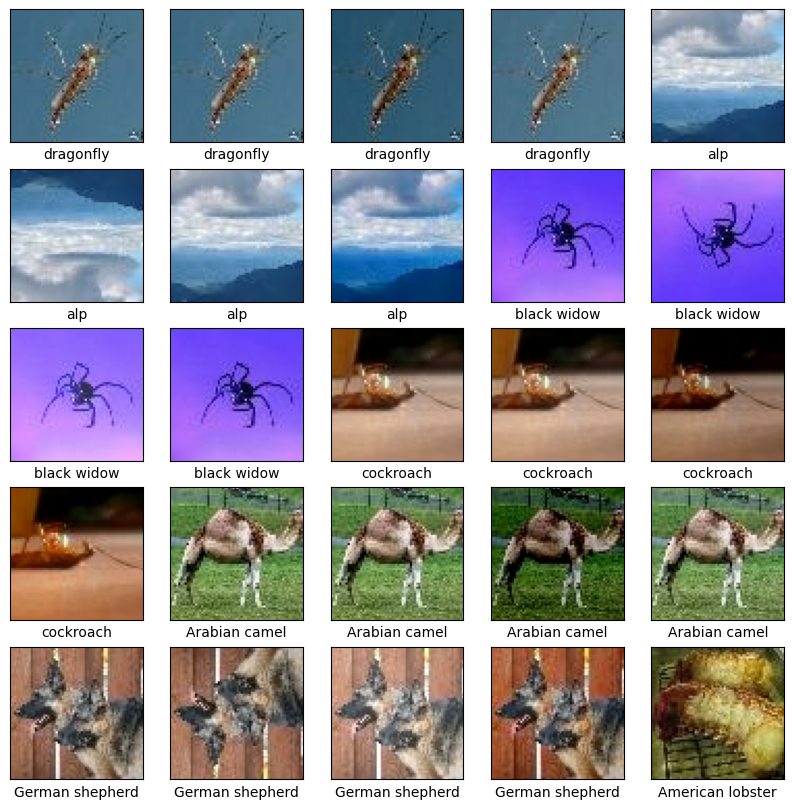

In [17]:
# Take one element from the dataset
sample = ds_augumented_train.take(1)

plt.figure(figsize=(10,10))
# Iterate through the dataset and print images and label
for image, label in sample:
    # print( label)
    # Convert image tensor to NumPy array for visualization
    image_np = image.numpy()
    print("Image shape:", image_np.shape)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_np[i])
        plt.xlabel(limited_classes[np.argmax(label[i])])
    plt.show()
    break

Image shape: (64, 64, 64, 3)


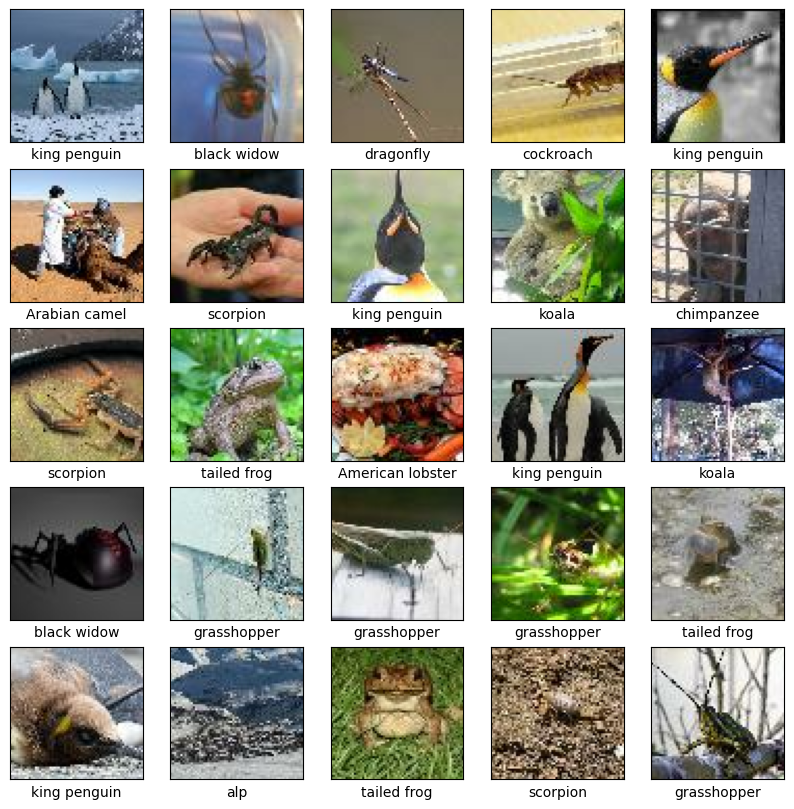

In [8]:
# Take one element from the dataset
sample = ds_valid.take(1)

plt.figure(figsize=(10,10))
# Iterate through the dataset and print images and label
for image, label in sample:
    # print( label)
    # Convert image tensor to NumPy array for visualization
    image_np = image.numpy()
    print("Image shape:", image_np.shape)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_np[i])
        plt.xlabel(limited_classes[np.argmax(label[i])])
    plt.show()
    break



Image shape: (64, 64, 64, 3)


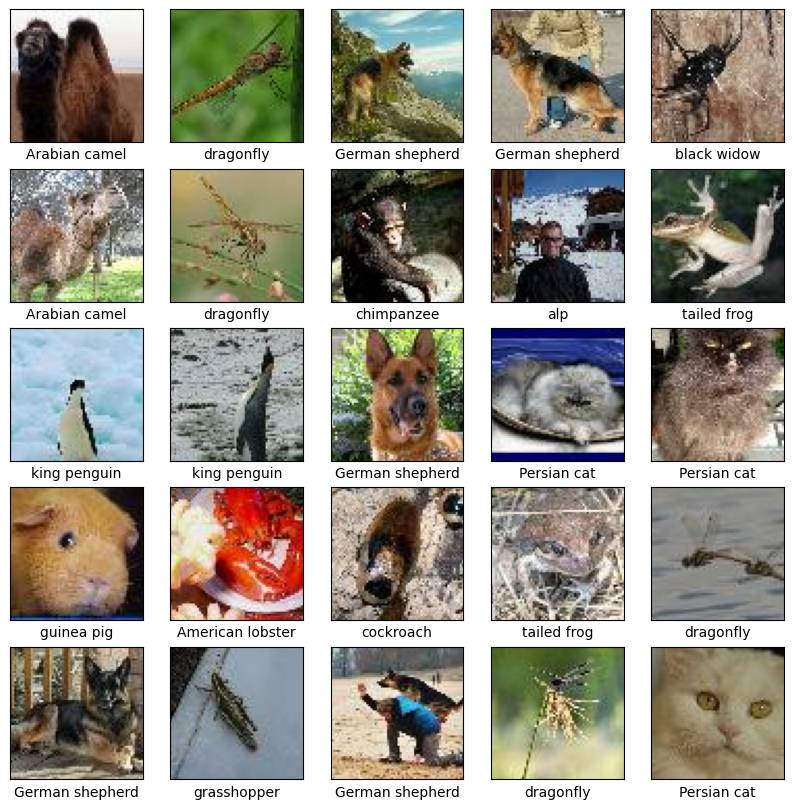

In [9]:
# Take one element from the dataset
sample = ds_train.take(1)

plt.figure(figsize=(10,10))
# Iterate through the dataset and print images and label
for image, label in sample:
    # Convert image tensor to NumPy array for visualization
    image_np = image.numpy()
    print("Image shape:", image_np.shape)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_np[i])
        plt.xlabel(limited_classes[np.argmax(label[i])])

    plt.show()
    break



In [16]:
## plot functions 
def plot_hist_loss(hist):
    plt.plot(hist.history['loss'], label='Training Loss')
    plt.plot(hist.history['val_loss'], label='Validation Loss')
    plt.title("Training loss VS Validation loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()
    
def plot_hist(hist):
    plt.plot(hist.history["accuracy"], label='Training Accuracy')
    plt.plot(hist.history["val_accuracy"], label='Validation Accuracy')
    plt.title("Training Accuracy VS Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()

def plot_hist_all(hist, hist1, hist2, hist3):
    plt.figure(figsize=(10, 6))
    plt.plot(hist.history['accuracy'], label='Train-WOR Loss')
    plt.plot(hist.history['val_accuracy'], label='Validation-WOR Loss')
    plt.plot(hist1.history["accuracy"], label='Train-L2 Loss')
    plt.plot(hist1.history["val_accuracy"], label='Validation-L2 Loss')
    plt.plot(hist2.history["accuracy"], label='Train-Dropout Loss')
    plt.plot(hist2.history["val_accuracy"], label='Validation-Dropout Loss')
    plt.plot(hist3.history["accuracy"], label='Train-Ensemble Loss')
    plt.plot(hist3.history["val_accuracy"], label='Validation-Ensemble Loss')
    plt.title("Training Accuracy VS Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()
    
def plot_hist_all_loss(hist, hist1, hist2, hist3):
    plt.figure(figsize=(10, 6))
    plt.plot(hist.history['loss'], label='Train-WOR Loss')
    plt.plot(hist.history['val_loss'], label='Validation-WOR Loss')
    plt.plot(hist1.history["loss"], label='Train-L2 Loss')
    plt.plot(hist1.history["val_loss"], label='Validation-L2 Loss')
    plt.plot(hist2.history["loss"], label='Train-Dropout Loss')
    plt.plot(hist2.history["val_loss"], label='Validation-Dropout Loss')
    plt.plot(hist3.history["loss"], label='Train-Ensemble Loss')
    plt.plot(hist3.history["val_loss"], label='Validation-Ensemble Loss')
    plt.title("Training loss VS Validation loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()
    
def plot_hist_comp(hist, hist1, label1 , label2):
    plt.figure(figsize=(10, 6))
    plt.plot(hist.history['accuracy'], label='Train-WOR Accuracy', color="green")
    plt.plot(hist.history['val_accuracy'], label='Validation-WOR Accuracy', linestyle=':', color="green")
    plt.plot(hist1.history["accuracy"], label= label1, color="orange")
    plt.plot(hist1.history["val_accuracy"], label= label2, linestyle=':', color="orange")
    plt.title("Training Accuracy VS Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()
    
def plot_hist_comp_loss(hist, hist1,label1 , label2 ):
    plt.figure(figsize=(10, 6))
    plt.plot(hist.history['loss'], label='Train-WOR Loss', color="green")
    plt.plot(hist.history['val_loss'], label='Validation-WOR Loss', linestyle=':', color="green")
    plt.plot(hist1.history["loss"], label= label1, color="orange")
    plt.plot(hist1.history["val_loss"], label= label2, linestyle=':', color="orange")
    plt.title("Training loss VS Validation loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()

In [14]:
# Define the input shape
input_shape = [None, IMG_SIZE, IMG_SIZE, 3]

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=(11, 11), strides=4, activation='relu', padding='same', input_shape=input_shape[1:]),
    tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Conv2D(192, kernel_size=(5, 5), activation='relu', padding='same'),
    tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy'])

# Print the model summary
print(model.summary())

class LogMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, filename):
        super(LogMetricsCallback, self).__init__()
        self.filename = filename
        # Initialize the file with headers
        with open(self.filename, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy'])

    def on_epoch_end(self, epoch, logs=None):
        with open(self.filename, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch, logs['loss'], logs['accuracy'], logs['val_loss'], logs['val_accuracy']])

output_file = "model.csv"
log_metrics_callback = LogMetricsCallback(output_file)
# Train the model
model_output = model.fit(
    ds_train, 
    epochs=EPOCHS, 
    validation_data=ds_valid, 
    batch_size=BATCH_SIZE,
    callbacks=[log_metrics_callback],
    )

# Evaluate the model
loss, accuracy = model.evaluate(ds_valid)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

/Users/hrishikesh/miniconda3/envs/MLCS_project/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 16, 64)     │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 192)      │       307,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 384)      │       663,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │        15,375 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,321,679 (20.30 MB)

 Trainable params: 5,321,679 (20.30 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 172ms/step - accuracy: 0.0656 - loss: 3.7641 - val_accuracy: 0.0668 - val_loss: 2.7102
Epoch 2/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 171ms/step - accuracy: 0.0815 - loss: 2.7033 - val_accuracy: 0.0696 - val_loss: 2.7084
Epoch 3/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 171ms/step - accuracy: 0.0640 - loss: 2.7013 - val_accuracy: 0.1463 - val_loss: 2.5536
Epoch 4/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 22s 190ms/step - accuracy: 0.1418 - loss: 2.5687 - val_accuracy: 0.1690 - val_loss: 2.5005
Epoch 5/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 23s 195ms/step - accuracy: 0.1769 - loss: 2.4726 - val_accuracy: 0.1989 - val_loss: 2.4286
Epoch 6/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 22s 184ms/step - accuracy: 0.2118 - loss: 2.3791 - val_accuracy: 0.2415 - val_loss: 2.3097
Epoch 7/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 180ms/step - accuracy: 0.2516 - loss: 2.2792 - val_accuracy: 0.2500 - val_loss: 2.2777
Epoch 8/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 23s 195ms/step - accuracy: 0.2644 - lo

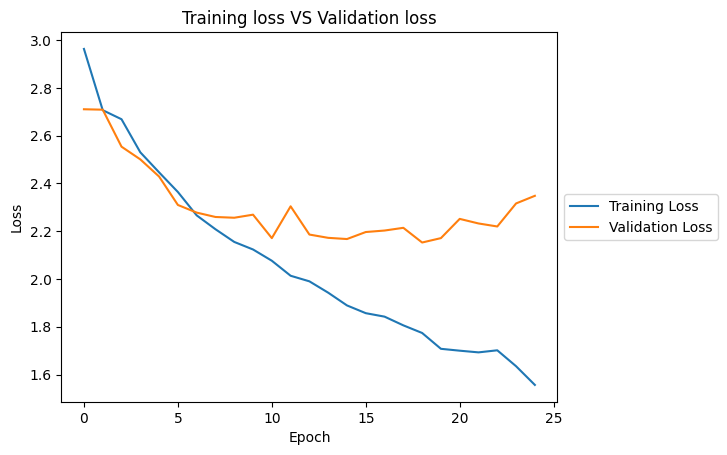

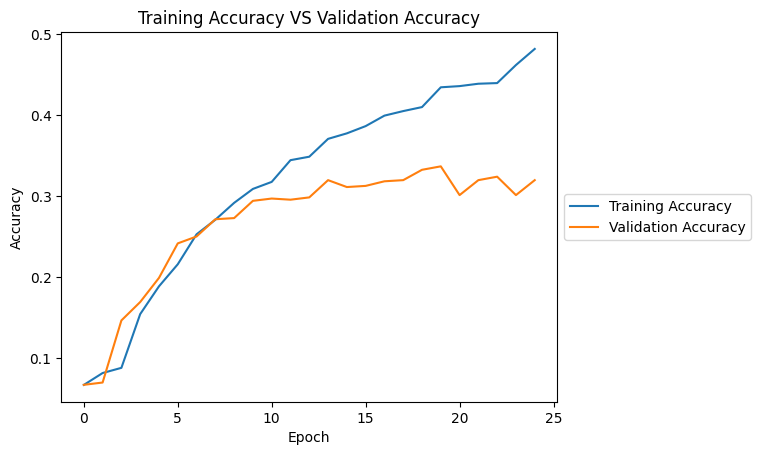

In [15]:
plot_hist_loss(model_output)
plot_hist(model_output)

In [13]:
# Define the input shape
input_shape = [None, IMG_SIZE, IMG_SIZE, 3]

# Define the model architecture
model_l2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=(11, 11), strides=4, activation='relu', padding='same', input_shape=input_shape[1:]),
    tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Conv2D(192, kernel_size=(5, 5), activation='relu', padding='same'),
    tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00002)),
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00002)),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model_l2.compile(
    optimizer="adam", 
    loss="categorical_crossentropy",
    metrics=['accuracy'])

# Print the model summary
print(model_l2.summary())

class LogMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, filename):
        super(LogMetricsCallback, self).__init__()
        self.filename = filename
        # Initialize the file with headers
        with open(self.filename, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy'])

    def on_epoch_end(self, epoch, logs=None):
        with open(self.filename, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch, logs['loss'], logs['accuracy'], logs['val_loss'], logs['val_accuracy']])

output_file = "model_l2.csv"
log_metrics_callback = LogMetricsCallback(output_file)
# Train the model
model_output_l2 = model_l2.fit(
    ds_train, 
    epochs=EPOCHS, 
    validation_data=ds_valid, 
    batch_size=BATCH_SIZE,
    callbacks = [log_metrics_callback]
    )

# Evaluate the model
loss, accuracy = model_l2.evaluate(ds_valid)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

/Users/hrishikesh/miniconda3/envs/NLP/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 16, 64)     │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 192)      │       307,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 384)      │       663,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │        15,375 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,321,679 (20.30 MB)

 Trainable params: 5,321,679 (20.30 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 174ms/step - accuracy: 0.0696 - loss: 4.4620 - val_accuracy: 0.0653 - val_loss: 2.7365
Epoch 2/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 173ms/step - accuracy: 0.0617 - loss: 2.7367 - val_accuracy: 0.0653 - val_loss: 2.7346
Epoch 3/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 177ms/step - accuracy: 0.0641 - loss: 2.7346 - val_accuracy: 0.0966 - val_loss: 2.7311
Epoch 4/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 176ms/step - accuracy: 0.0851 - loss: 2.7098 - val_accuracy: 0.1307 - val_loss: 2.5700
Epoch 5/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 183ms/step - accuracy: 0.1367 - loss: 2.5996 - val_accuracy: 0.1804 - val_loss: 2.5487
Epoch 6/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 22s 185ms/step - accuracy: 0.1738 - loss: 2.5235 - val_accuracy: 0.2003 - val_loss: 2.4727
Epoch 7/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 178ms/step - accuracy: 0.1902 - loss: 2.4406 - val_accuracy: 0.2259 - val_loss: 2.4155
Epoch 8/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 182ms/step - accuracy: 0.2312 - lo

In [13]:
def load_history_from_csv(filename):
    df = pd.read_csv(filename)
    history = {
        "loss": df["train_loss"].tolist(),
        "accuracy": df["train_accuracy"].tolist(),
        "val_loss": df["val_loss"].tolist(),
        "val_accuracy": df["val_accuracy"].tolist()
    }
    return history
class MockHistory:
    def __init__(self, history):
        self.history = history
# Load the CSV data
model_results = load_history_from_csv("model.csv")
model_l2_results = load_history_from_csv("model_l2.csv")
# model_dropout_results = load_history_from_csv("model_dropout.csv")
# model_ensemble_results = load_history_from_csv("model_ensemble.csv")

model_results = MockHistory(model_results)
model_l2_results = MockHistory(model_l2_results)
# model_dropout_results = MockHistory(model_dropout_results)
# model_ensemble_results = MockHistory(model_ensemble_results)

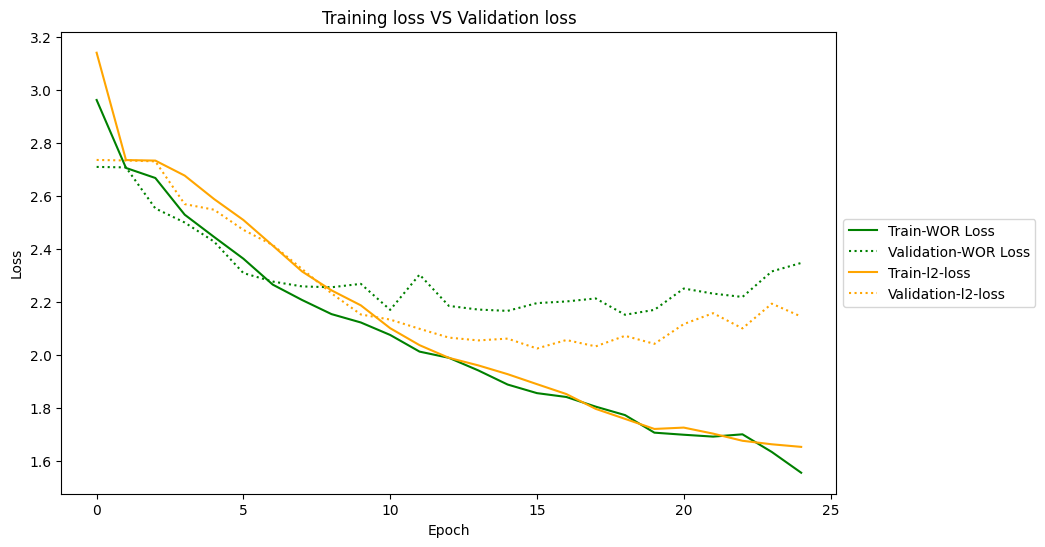

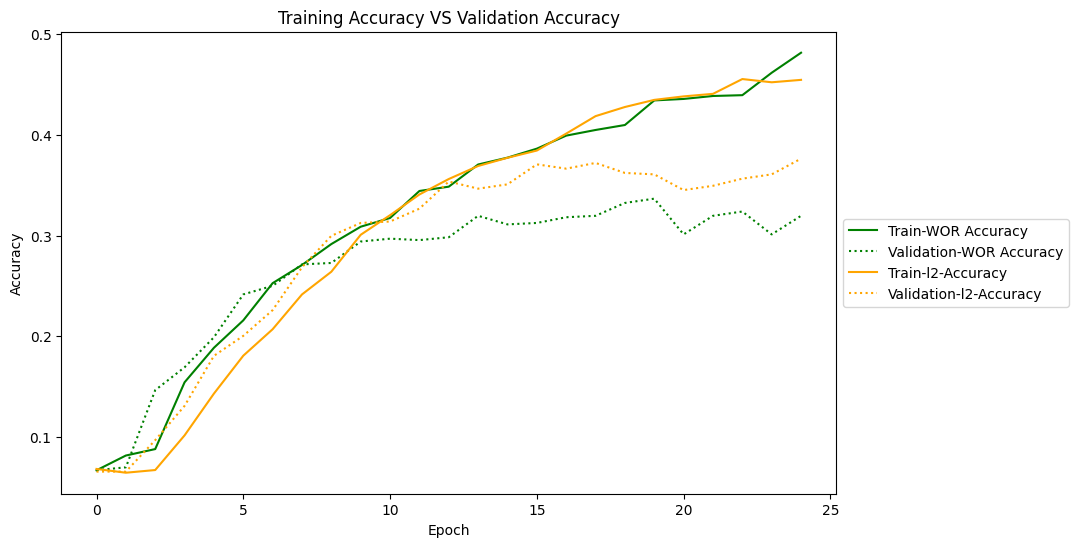

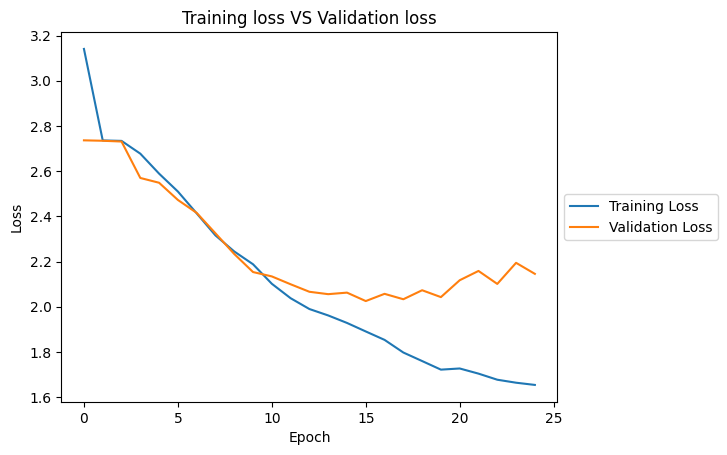

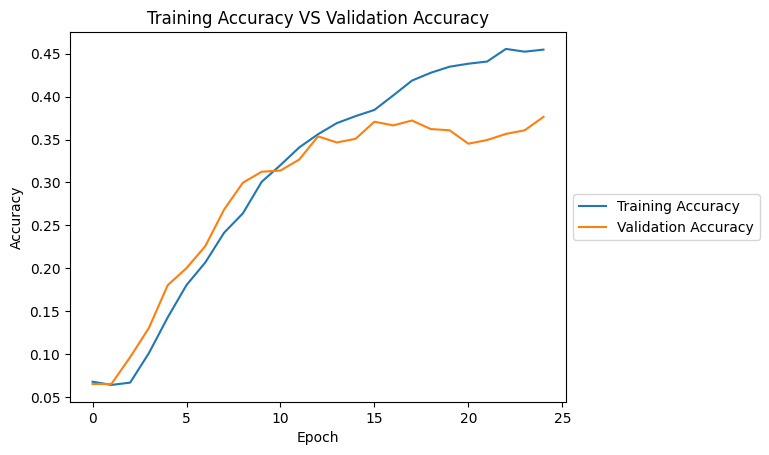

In [30]:
plot_hist_comp_loss(model_results , model_l2_results ,"Train-l2-loss" , "Validation-l2-loss")
plot_hist_comp(model_results , model_l2_results, "Train-l2-Accuracy" , "Validation-l2-Accuracy")
plot_hist_loss(model_output_l2)
plot_hist(model_output_l2)

In [31]:
# Define the input shape
input_shape = [None, IMG_SIZE, IMG_SIZE, 3]

# Define the model architecture
model_dropout = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=(11, 11), strides=4, activation='relu', padding='same', input_shape=input_shape[1:]),
    tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Conv2D(192, kernel_size=(5, 5), activation='relu', padding='same'),
    tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model_dropout.compile(
    optimizer="adam",  
    loss="categorical_crossentropy",
    metrics=['accuracy'])

# Print the model summary
print(model_dropout.summary())

class LogMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, filename):
        super(LogMetricsCallback, self).__init__()
        self.filename = filename
        # Initialize the file with headers
        with open(self.filename, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy'])

    def on_epoch_end(self, epoch, logs=None):
        with open(self.filename, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch, logs['loss'], logs['accuracy'], logs['val_loss'], logs['val_accuracy']])

output_file = "model_dropout.csv"
log_metrics_callback = LogMetricsCallback(output_file)
# Train the model
model_output_dropout = model_dropout.fit(
    ds_train, 
    epochs=EPOCHS, 
    validation_data=ds_valid, 
    batch_size=BATCH_SIZE,
    callbacks=[log_metrics_callback]
    )

# Evaluate the model
loss, accuracy = model_dropout.evaluate(ds_valid)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

/Users/hrishikesh/miniconda3/envs/NLP/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 192)      │       307,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 384)      │       663,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │        15,375 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,321,679 (20.30 MB)

 Trainable params: 5,321,679 (20.30 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 165ms/step - accuracy: 0.0634 - loss: 3.4329 - val_accuracy: 0.0682 - val_loss: 2.7195
Epoch 2/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 18s 154ms/step - accuracy: 0.0836 - loss: 2.7023 - val_accuracy: 0.0653 - val_loss: 2.7087
Epoch 3/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 19s 163ms/step - accuracy: 0.0557 - loss: 2.7095 - val_accuracy: 0.0696 - val_loss: 2.7080
Epoch 4/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 19s 164ms/step - accuracy: 0.0674 - loss: 2.7080 - val_accuracy: 0.1222 - val_loss: 2.6254
Epoch 5/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 183ms/step - accuracy: 0.1078 - loss: 2.6364 - val_accuracy: 0.1449 - val_loss: 2.5763
Epoch 6/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 22s 185ms/step - accuracy: 0.1478 - loss: 2.5446 - val_accuracy: 0.1733 - val_loss: 2.4850
Epoch 7/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 24s 208ms/step - accuracy: 0.1673 - loss: 2.5068 - val_accuracy: 0.1733 - val_loss: 2.4656
Epoch 8/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 28s 239ms/step - accuracy: 0.1766 - lo

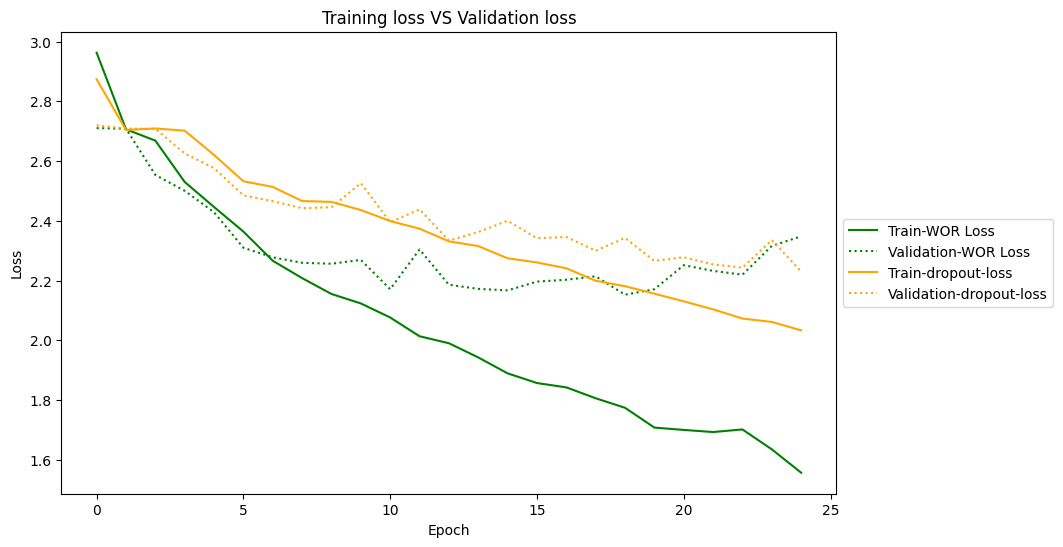

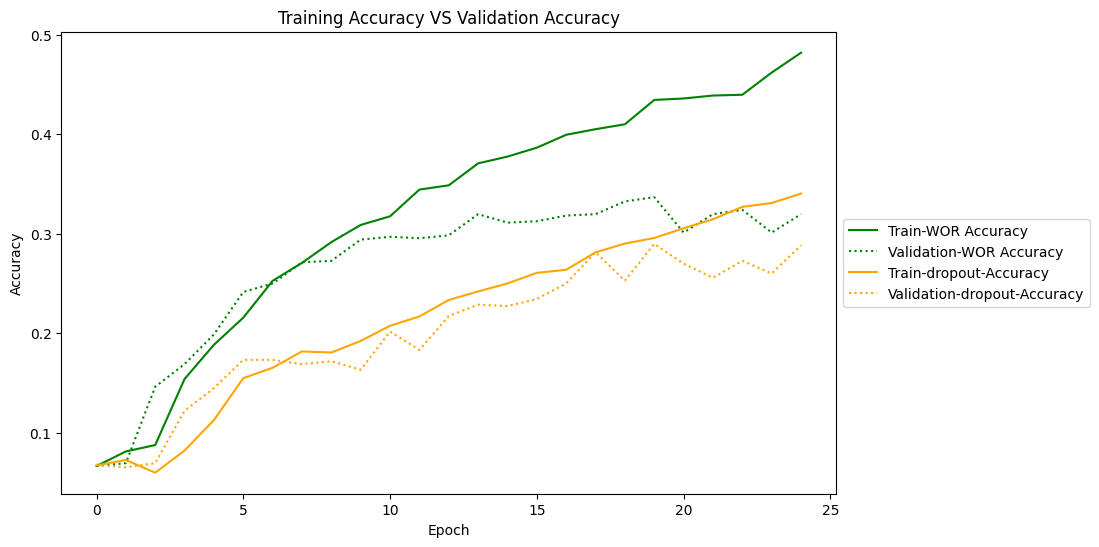

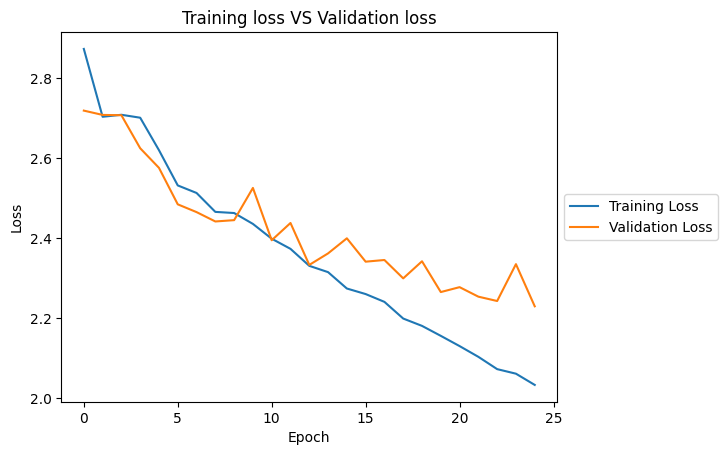

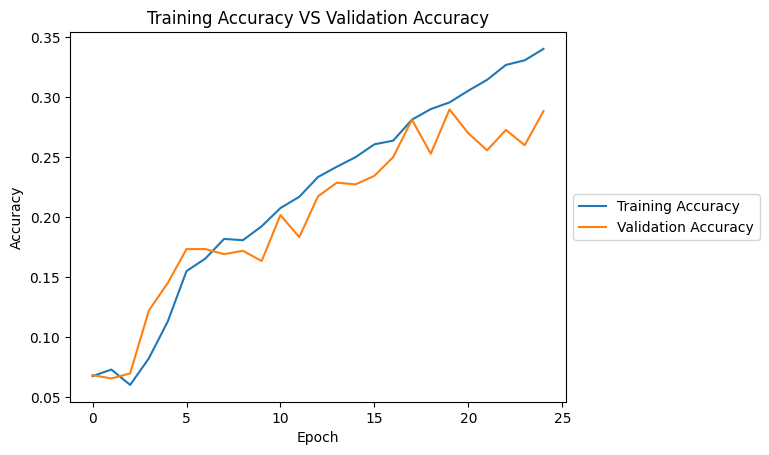

In [34]:
# Load the CSV data
model_results = load_history_from_csv("model.csv")
model_dropout_results = load_history_from_csv("model_dropout.csv")
# model_ensemble_results = load_history_from_csv("model_ensemble.csv")

model_results = MockHistory(model_results)
model_dropout_results = MockHistory(model_dropout_results)
# model_ensemble_results = MockHistory(model_ensemble_results)

plot_hist_comp_loss(model_results , model_dropout_results ,"Train-dropout-loss" , "Validation-dropout-loss")
plot_hist_comp(model_results , model_dropout_results, "Train-dropout-Accuracy" , "Validation-dropout-Accuracy")
plot_hist_loss(model_output_dropout)
plot_hist(model_output_dropout)

In [11]:
# Define the input shape
input_shape = [None, IMG_SIZE, IMG_SIZE, 3]

# Define the model architecture
model_ensemble = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=(11, 11), strides=4, activation='relu', padding='same', input_shape=input_shape[1:]),
    tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Conv2D(192, kernel_size=(5, 5), activation='relu', padding='same'),
    tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00002)),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00002)),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model_ensemble.compile(
    optimizer="adam", 
    loss="categorical_crossentropy",
    metrics=['accuracy'])

# Print the model summary
print(model_ensemble.summary())

class LogMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, filename):
        super(LogMetricsCallback, self).__init__()
        self.filename = filename
        # Initialize the file with headers
        with open(self.filename, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy'])

    def on_epoch_end(self, epoch, logs=None):
        with open(self.filename, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch, logs['loss'], logs['accuracy'], logs['val_loss'], logs['val_accuracy']])

output_file = "model_ensemble.csv"
log_metrics_callback = LogMetricsCallback(output_file)
# Train the model
model_output_ensemble = model_ensemble.fit(
    ds_train, 
    epochs=EPOCHS, 
    validation_data=ds_valid, 
    batch_size=BATCH_SIZE,
    callbacks=[log_metrics_callback]
    )

# Evaluate the model
loss, accuracy = model_ensemble.evaluate(ds_valid)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

/Users/hrishikesh/miniconda3/envs/MLCS_project/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 16, 64)     │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 192)      │       307,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 384)      │       663,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │        15,375 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,321,679 (20.30 MB)

 Trainable params: 5,321,679 (20.30 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 171ms/step - accuracy: 0.0719 - loss: 3.3492 - val_accuracy: 0.0682 - val_loss: 2.7467
Epoch 2/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 19s 167ms/step - accuracy: 0.0757 - loss: 2.7294 - val_accuracy: 0.1506 - val_loss: 2.6231
Epoch 3/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 169ms/step - accuracy: 0.1376 - loss: 2.6114 - val_accuracy: 0.1321 - val_loss: 2.5627
Epoch 4/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 175ms/step - accuracy: 0.1699 - loss: 2.5019 - val_accuracy: 0.1463 - val_loss: 2.5664
Epoch 5/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 178ms/step - accuracy: 0.2138 - loss: 2.4153 - val_accuracy: 0.2415 - val_loss: 2.3666
Epoch 6/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 177ms/step - accuracy: 0.2510 - loss: 2.2998 - val_accuracy: 0.2330 - val_loss: 2.3636
Epoch 7/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 181ms/step - accuracy: 0.2685 - loss: 2.2623 - val_accuracy: 0.2514 - val_loss: 2.3021
Epoch 8/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 22s 188ms/step - accuracy: 0.2862 - lo

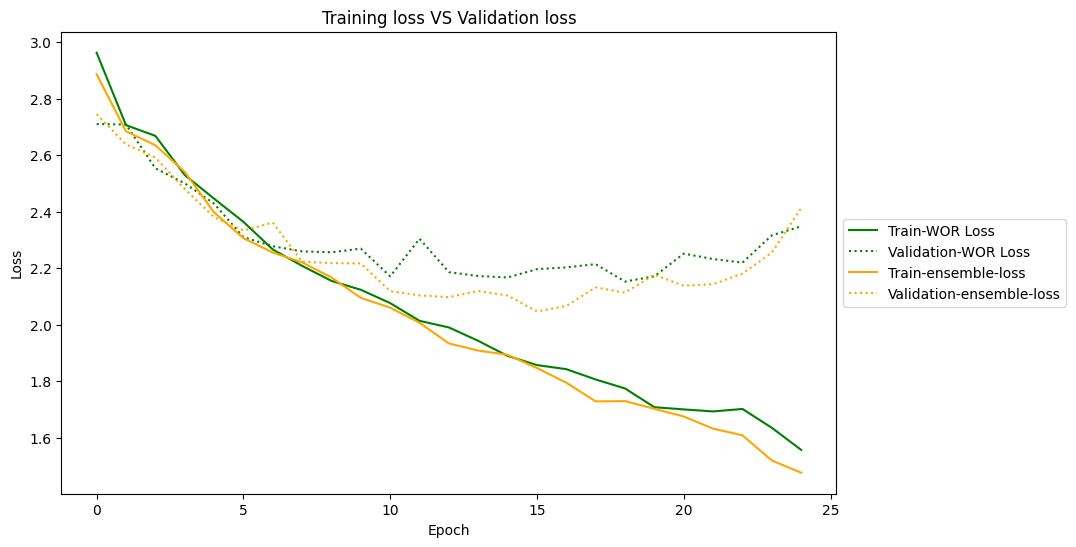

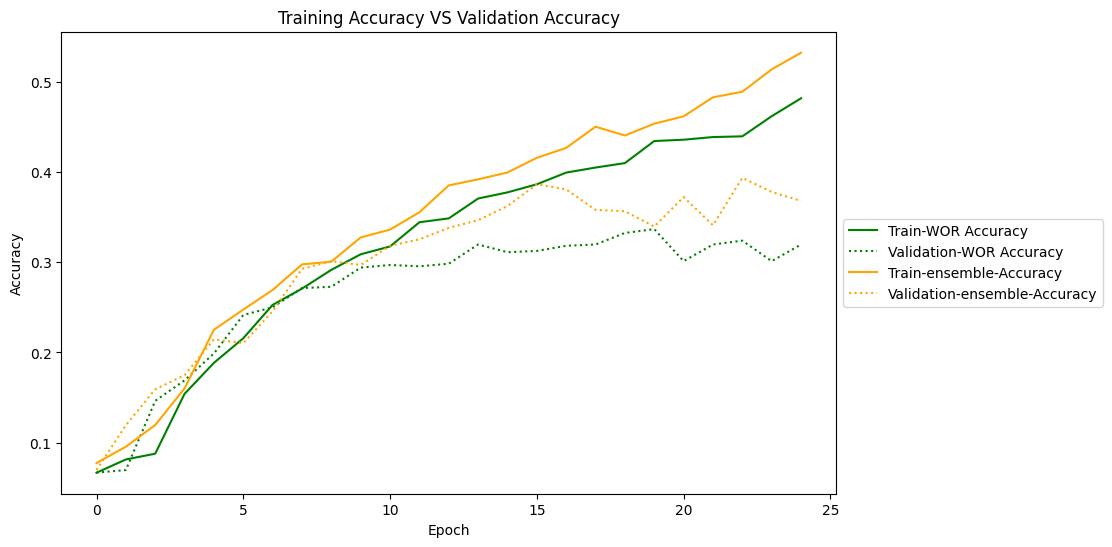

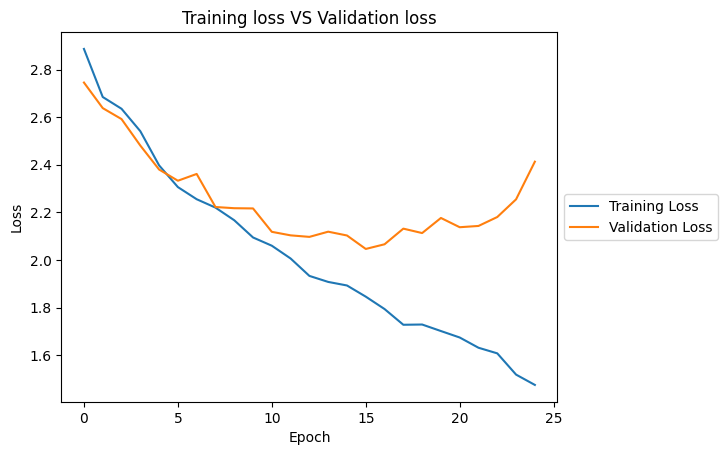

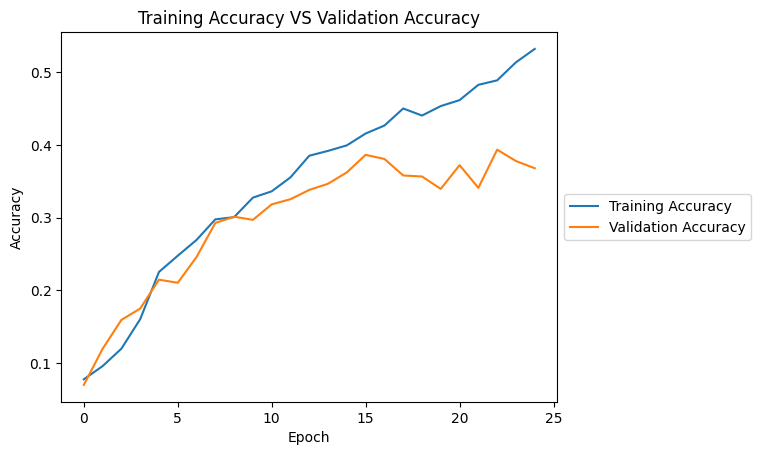

In [30]:
model_results = load_history_from_csv("model.csv")
model_ensemble_results = load_history_from_csv("model_ensemble.csv")
model_results = MockHistory(model_results)
model_ensemble_results = MockHistory(model_ensemble_results)
plot_hist_comp_loss(model_results , model_output_ensemble ,"Train-ensemble-loss" , "Validation-ensemble-loss")
plot_hist_comp(model_results , model_output_ensemble, "Train-ensemble-Accuracy" , "Validation-ensemble-Accuracy")
plot_hist_loss(model_output_ensemble)
plot_hist(model_output_ensemble)

In [21]:
# Define the input shape
input_shape = [None, IMG_SIZE, IMG_SIZE, 3]

# Define the model architecture
model_augmentation = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=(11, 11), strides=4, activation='relu', padding='same', input_shape=input_shape[1:]),
    tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Conv2D(192, kernel_size=(5, 5), activation='relu', padding='same'),
    tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model_augmentation.compile(
    optimizer="adam", 
    loss="categorical_crossentropy",
    metrics=['accuracy'])

# Print the model summary
print(model_augmentation.summary())

class LogMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, filename):
        super(LogMetricsCallback, self).__init__()
        self.filename = filename
        # Initialize the file with headers
        with open(self.filename, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy'])

    def on_epoch_end(self, epoch, logs=None):
        with open(self.filename, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch, logs['loss'], logs['accuracy'], logs['val_loss'], logs['val_accuracy']])

output_file = "model_augmentation.csv"
log_metrics_callback = LogMetricsCallback(output_file)
# Train the model
model_output_augmentation = model_augmentation.fit(
    ds_augumented_train, 
    epochs=EPOCHS, 
    validation_data=ds_valid, 
    batch_size=BATCH_SIZE,
    callbacks = [log_metrics_callback]
    )

# Evaluate the model
loss, accuracy = model_output_augmentation.evaluate(ds_valid)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

/Users/hrishikesh/miniconda3/envs/MLCS_project/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 192)      │       307,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 384)      │       663,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │        15,375 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,321,679 (20.30 MB)

 Trainable params: 5,321,679 (20.30 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
468/468 ━━━━━━━━━━━━━━━━━━━━ 78s 163ms/step - accuracy: 0.0616 - loss: 3.0682 - val_accuracy: 0.0668 - val_loss: 2.7082
Epoch 2/25
468/468 ━━━━━━━━━━━━━━━━━━━━ 80s 171ms/step - accuracy: 0.0562 - loss: 2.7086 - val_accuracy: 0.0668 - val_loss: 2.7082
Epoch 3/25
468/468 ━━━━━━━━━━━━━━━━━━━━ 88s 187ms/step - accuracy: 0.0612 - loss: 2.7137 - val_accuracy: 0.0668 - val_loss: 2.7083
Epoch 4/25
468/468 ━━━━━━━━━━━━━━━━━━━━ 88s 188ms/step - accuracy: 0.0589 - loss: 2.7091 - val_accuracy: 0.0668 - val_loss: 2.7082
Epoch 5/25
468/468 ━━━━━━━━━━━━━━━━━━━━ 82s 175ms/step - accuracy: 0.0563 - loss: 2.7086 - val_accuracy: 0.0668 - val_loss: 2.7081
Epoch 6/25
468/468 ━━━━━━━━━━━━━━━━━━━━ 82s 176ms/step - accuracy: 0.0566 - loss: 2.7085 - val_accuracy: 0.0668 - val_loss: 2.7082
Epoch 7/25
468/468 ━━━━━━━━━━━━━━━━━━━━ 84s 180ms/step - accuracy: 0.0518 - loss: 2.7086 - val_accuracy: 0.0668 - val_loss: 2.7081
Epoch 8/25
346/468 ━━━━━━━━━━━━━━━━━━━━ 23s 196ms/step - accuracy: 0.0549 - lo

In [340]:
# def load_history_from_csv(filename):
#     df = pd.read_csv(filename)
#     history = {
#         "loss": df["train_loss"].tolist(),
#         "accuracy": df["train_accuracy"].tolist(),
#         "val_loss": df["val_loss"].tolist(),
#         "val_accuracy": df["val_accuracy"].tolist()
#     }
#     return history
# # Load the CSV data
# model_results = load_history_from_csv("model.csv")
# model_l2_results = load_history_from_csv("model_l2.csv")
# model_dropout_results = load_history_from_csv("model_dropout.csv")
# model_ensemble_results = load_history_from_csv("model_ensemble.csv")
# class MockHistory:
#     def __init__(self, history):
#         self.history = history
# model_results = MockHistory(model_results)
# model_l2_results = MockHistory(model_l2_results)
# model_dropout_results = MockHistory(model_dropout_results)
# model_ensemble_results = MockHistory(model_ensemble_results)

# Regularization Techniques for Dataset 1

In [343]:
# 1. L2 Regularization - modifies the loss function. Applied to both datasets.
# 2. Data Augmentation - modifies the data. For Dataset1 we plan to use RandomErasing
#              - RandomErasing is concerned about removing and randomly adding information on the
#               blank space, such as noise. For Dataset2 we plan to use Random Synonym Replacement -
#               Random Synonym Replacement is concerned about removing and replacing with a synonym.
# 3. MaxDropout - modifies training approach. Applied to both datasets.
# 4. Ensemble Regularization 1 - applying RandomErasing and MaxDropout together. Applied to Dataset1.